# Weighted Shortest Path Analysis


Maps are especially useful as navigational aids - with relevant, accurate and complete location data, people can find the most efficient route from A to B. 

Exploring the Hampshire countryside by bike, our development team got to thinking: could we develop a tool to work out the optimal bike route between two places? We prefer riding on quieter roads, which are often more scenic, and are willing to ride a bit further to experience the scenery and avoid busy roads.

In this tutorial, we will us the [OS Features API](https://osdatahub.os.uk/docs/wfs/overview) `Highways_RoadLink` feature type and the [NetworkX Python package](https://networkx.org/) to create a graph of the road network in an area in Hampshire. Then we'll develop a way to weight each road segment based on length, elevation gained / lost and the "form of way", which refers to road size.

We'll use these weights to calculate the _weighted_ shortest path between points: a cycling route optimized for our preferences. By incorporating this weighting function, users can alter their preferred path based on the attributes of road segments en route. For example, a cyclist might want to stick to very small roads, so larger roads will have a higher weight - or commercial trucking operators might want to avoid steep hills, or only travel on large roads. 

⚠️⚠️⚠️ _It's important to note that this tool is **for learning purposes only**, and should not be used as a routing system. Other factors might contribute to the safety of these routes!_ 

## Packages

We use a few open source python packages in our code, and connect to two APIs accessible via the [OS Data Hub](https://osdatahub.os.uk/).

[Geopandas](https://geopandas.org/index.html): "an open source project to make working with geospatial data in python easier". Geopandas adds geospatial functionality to the popular [Pandas](https://pandas.pydata.org/) data analysis library. If you're not familiar, read [10 minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html).

[NetworkX](https://networkx.org/) "is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks." A network is a set of **nodes**, connected by **links** (or **edges**). The OS Features API provides `Highways_RoadLink` data in the form of GeoJSON linestrings. We can build a network from this since the IDs of the nodes connected by the link linestring is stored in the `properties` of the feature:

~~~json
{
    "type": "Feature",
    "geometry": {
        "coordinates": [
            [ -0.887902,50.994843 ],
            [ -0.887922, 50.995378 ],
            [ -0.887996, 50.996639 ],
            [ -0.887992, 50.996783 ]
        ],
        "type": "LineString"
    },
    "properties": {
                    ...
                    "StartNode": "osgb4000000023147283",
                    "EndNode": "osgb4000000023147284",
                    ...
     }
}
~~~

[Folium](https://python-visualization.github.io/folium/) allows us to create Leaflet maps in our IPython Notebook, so we can visualise the results of our analysis.

And the [OS Python API Wrapper](https://pypi.org/project/os-paw/) is a new tool we've launched to make working with OS Data Hub APIs a breeze for Python developers. At this point, it is a prototype tool - so if you catch any bugs or want to contribute a feature, [open an issue on our Github](https://github.com/OrdnanceSurvey/OS-PAW/issues).

We'll also use matplotlib for some quick visualisation and standard Python libraries like os, sys and json:


In [1]:
import os
import sys
import json
import glob
import folium
import pandas as pd
import geopandas as gpd
import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt
from os_paw.wfs_api import WFS_API
from folium.plugins import FloatImage

print('=> Imported libraries')

=> Imported libraries


## APIs

Location data is fetched from OS Data Hub APIs. These APIs are designed to give developers and data scientists access to current, high resolution location data on demand. If you don't already have one, go sign up for an account on the [OS Data Hub](https://osdatahub.os.uk/). 

Our analysis here uses Premium data from the OS Features API, so you will need a Premium account. But - you can get up to £1000 of OS data free of charge each month. Furthermore, you can set your API key to "Development Mode" - transactions submitted with that key will not be charged. 

For this to work properly, create a project on a Premium OS Data Hub account and enable the OS Maps API and OS Features API. 

Paste your key below 👇

In [2]:
# Set API key, copied from osdatahub.os.uk. 
    # (This tutorial requires a project key with the OS Features 
    # and OS Maps APIs enabled from a Premium account!)
key = 'JydUr1HO7ejqBhw0YP19W3b1GonFwmzr'

And create an instance of the OS Python API Wrapper:

In [3]:
# Create WFS API instance 
wfs_api = WFS_API(api_key=key)

## Fetching data

Next we'll fetch data within a bounding box using the `get_all_features_within_bbox` method. We'll need to specify which feature type we'll want features from - for a full list see the [docs](https://osdatahub.os.uk/docs/wfs/technicalSpecification). (Note how some feature types are Premium and some are Open Data.)

We will need to specify certain arguments the wrapper needs to have to construct a valid request, including:
- Feature type
- Spatial reference system (`EPSG:4326` or `EPSG:27700`)
- Bounding box (a string with `"lower left latitude, lower left longitude, upper right latitude, upper right longitude"`)
- Set the `allow_premium` flag to `True`

Note that currently the Python API Wrapper is configured to [limit requests to 1000 features](https://github.com/OrdnanceSurvey/OS-PAW/blob/7b039d64f14cdb5e1f9215654840518feb16b5ad/os_paw/wfs_api.py#L48), or 10 transactions of 100 features each, by default. This is to prevent users from unintentionally racking up large bills by submitting a request that loops through hundreds of Premium transactions - but it can be overridden by setting `max_feature_count` equal to whatever number you'd like to request. Careful here - be sure you're in Development Mode while testing this, or you might accidentally run up costs!

In [4]:
# Fetch geometries from Highways_Roadlink feature type
    # ☝️ Remember to switch your API key to "Development Mode" 
    # while you're experimenting as this is a Premium dataset!
    
data = wfs_api.get_all_features_within_bbox(type_name="Highways_RoadLink",
                                            bbox="50.958859,-0.831871, 51.025201,-0.6667327",
                                            srs='EPSG:4326',
                                            allow_premium=True,
                                            max_feature_count=2000
                                           )
                # There are fewer than 1000 Highway_RoadLink features in the bounding box we're 
                # providing - if you change that you may need to add max_feature_count=5000 or more.

## Building our GeoDataFrame

Now that we've got a GeoJSON FeatureCollection assigned to the `data` variable, we are ready to create a geopandas GeoDataFrame. Geopandas plays well with GeoJSON, so this is quite simple. We will also [cast a few of the columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html) `to_numeric` data types, so they behave as we expect when we start doing arithmetic on them.

We'll call the variable `gdf` - short for `GeoDataFrame`, a common convention in the (geo)pandas community.

In [5]:
# Create GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(data, crs=data['crs'])

In [6]:
# Convert GeoDataFrame column data types 
gdf['Length'] = pd.to_numeric(gdf['Length'])
gdf['ElevationGainInDir'] = pd.to_numeric(gdf['ElevationGainInDir'])
gdf['ElevationGainInOppDir'] = pd.to_numeric(gdf['ElevationGainInOppDir'])

#### Grade Separation

The OS MasterMap Highways network uses the `StartGradeSeparation` and `EndGradeSeparation` dimensions to indicate where two roads cross but don't adjoin - i.e., bridges, overpasses etc. 

```
    | |
    | |
=====*======
    | |
    | |
```

The road passing underneath is assigned a grade separation of 0, the overpass is 1.

To handle this in our analysis, we'll make a simple adjustment by concatenating the road link's start and end node TOIDs with that row's respective start and end grade separation values. This will enable NetworkX to correctly interpret the relationship between links that share a node - the point where the two disconnected roads intersect.

We'll create two new columns, `StartNodeGraded` and `EndNodeGraded` to hold this information - so like this:

`<StartNode TOID>_<StartGradeSeparation>`


or

`osgb5000005162231053_0`


In [7]:
gdf['StartNodeGraded'] = gdf['StartNode'] + "_" + gdf['StartGradeSeparation'].apply(str)
gdf['EndNodeGraded'] = gdf['EndNode'] + "_" + gdf['EndGradeSeparation'].apply(str)

Great - data is loaded and ready to work with. Let's look at the first few rows we've loaded into the dataframe.

Notice how each row represents a feature, the linestring geometry is represented in the `geometry` column, and each attribute is represented in its own column - `ID`, `RoadClassification`, `StartNode` etc - [tidy data](https://vita.had.co.nz/papers/tidy-data.pdf)!

In [8]:
gdf.describe()

OBJECTID       Length  StartGradeSeparation  EndGradeSeparation  \
count  1.599000e+03  1599.000000                1599.0              1599.0   
mean   2.139153e+06   168.537542                   0.0                 0.0   
std    1.465457e+06   224.539051                   0.0                 0.0   
min    3.286000e+03     2.390000                   0.0                 0.0   
25%    7.833745e+05    33.985000                   0.0                 0.0   
50%    2.143081e+06    83.030000                   0.0                 0.0   
75%    3.274012e+06   208.300000                   0.0                 0.0   
max    5.239017e+06  1705.640000                   0.0                 0.0   

       ElevationGainInDir  ElevationGainInOppDir  SHAPE_Length  
count         1599.000000            1599.000000   1599.000000  
mean             2.708881               3.191119    168.540913  
std              5.916440               6.958568    224.539170  
min              0.000000               0.000000      2.388796  
25%              0.000000               0.000000     33.986851  
50%              0.600000               0.600000     83.034994  
75%              2.500000               2.800000    208.303590  
max             76.600000              86.900000   1705.639216

In [9]:
# Display head of GeoDataFrame
gdf.head(5)

geometry  OBJECTID  \
0  LINESTRING (-0.80663 51.01707, -0.80678 51.017...      3286   
1  LINESTRING (-0.68851 50.95846, -0.68851 50.958...      3321   
2  LINESTRING (-0.67444 50.96702, -0.67423 50.967...      3322   
3  LINESTRING (-0.76462 50.97894, -0.76423 50.979...      3527   
4  LINESTRING (-0.82552 51.00236, -0.82554 51.002...      3598   

                     ID                             Identifier  \
0  osgb4000000023271823  http://data.os.uk/id/4000000023271823   
1  osgb4000000023273730  http://data.os.uk/id/4000000023273730   
2  osgb4000000023273769  http://data.os.uk/id/4000000023273769   
3  osgb4000000023287869  http://data.os.uk/id/4000000023287869   
4  osgb4000000023290931  http://data.os.uk/id/4000000023290931   

   InspireIDNamespace  InspireIDLocalID Fictitious     RoadClassification  \
0  http://data.os.uk/  4000000023271823      false         Not Classified   
1  http://data.os.uk/  4000000023273730      false  Classified Unnumbered   
2  http://data.os.uk/  4000000023273769      false  Classified Unnumbered   
3  http://data.os.uk/  4000000023287869      false                Unknown   
4  http://data.os.uk/  4000000023290931      false           Unclassified   

                 RouteHierarchy           FormOfWay  ...  \
0  Restricted Local Access Road  Single Carriageway  ...   
1                    Minor Road  Single Carriageway  ...   
2                    Minor Road  Single Carriageway  ...   
3  Restricted Local Access Road               Track  ...   
4  Restricted Local Access Road  Single Carriageway  ...   

              StartNode               EndNode  \
0  osgb5000005162231053  osgb4000000023147628   
1  osgb4000000023174481  osgb4000000023174482   
2  osgb4000000023174913  osgb4000000023174918   
3  osgb5000005162231032  osgb4000000023129872   
4  osgb4000000023147525  osgb4000000023147494   

                                     RelatedRoadArea BeginLifespanVersion  \
0  osgb1000000138297773,osgb1000000138297784,osgb...            4/15/2017   
1  osgb1000002088373808,osgb5000005161696336,osgb...            4/15/2017   
2                               osgb1000000138384061            4/15/2017   
3  osgb1000000138326793,osgb1000000138326857,osgb...            4/15/2017   
4          osgb1000000138289310,osgb1000000138289392            4/15/2017   

  ValidForm                   ReasonForChange  \
0      null  Modified Geometry And Attributes   
1      null  Modified Geometry And Attributes   
2      null  Modified Geometry And Attributes   
3      null  Modified Geometry And Attributes   
4      null  Modified Geometry And Attributes   

                AlternateIdentifierScheme SHAPE_Length  \
0  NSG Elementary Street Unit ID (ESU ID)   518.386342   
1  NSG Elementary Street Unit ID (ESU ID)   386.111782   
2  NSG Elementary Street Unit ID (ESU ID)   523.107276   
3                                           151.148746   
4  NSG Elementary Street Unit ID (ESU ID)   218.118073   

          StartNodeGraded           EndNodeGraded  
0  osgb5000005162231053_0  osgb4000000023147628_0  
1  osgb4000000023174481_0  osgb4000000023174482_0  
2  osgb4000000023174913_0  osgb4000000023174918_0  
3  osgb5000005162231032_0  osgb4000000023129872_0  
4  osgb4000000023147525_0  osgb4000000023147494_0  

[5 rows x 61 columns]

We can also visualise a rudimentary plot of the dataframe. We'll build a more sophisticated map later on - this just shows the shape of the road network in this area.

(-0.84804135, -0.6506716499999998, 50.94764095, 51.03447605)

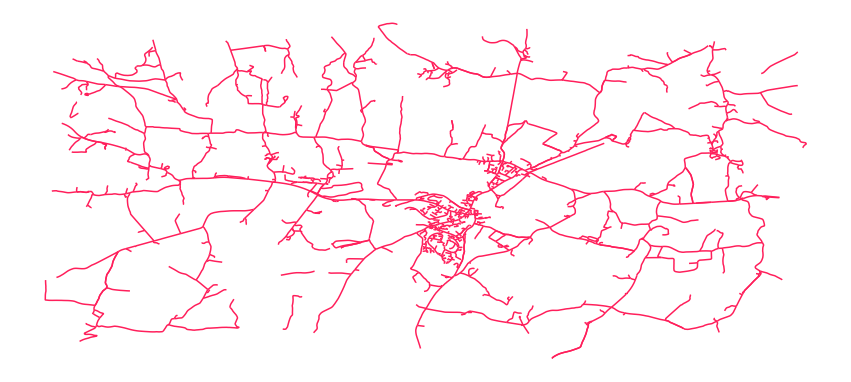

In [10]:
ax = gdf.plot(color='#ff1f5b', figsize=(15, 15))
# Turn plot axis off
ax.axis('off')

## Calculate weight

We will create a simple weighting algorithm, which we will assign as the path "weight" of a link in our graph. This weighting algorithm takes advantage of the fact that the OS Features API includes rich attribution with each geographic feature. 

For our use case - finding direct and low-traffic cycling routes - we will emphasize certain factors. Specifically, our weighting algorithm will integrate dimensions including: 

| Dimension | Affect on weight |
| --- | --- |
| `RouteHierarchy` | Smaller roads have lower weight |
| `Length` | Longer roads have greater weight  |
| `ElevationGainInDir` | Greater values have greater weight |
| `ElevationGainInOppDir` | Greater values have lower weight |

In [11]:


roadWeight = {
    'Restricted Local Access Road': 0, 
    'Minor Road': 10, 
    'Local Road': 20,
    'A Road': 100, 
    'A Road Primary': 150, 
    'Restricted Secondary Access Road': 0,
    'Local Access Road': 0, 
    'Secondary Access Road': 0
}


In [12]:
def cyclingWeight(row):
    
    weight = 0
    weight += roadWeight[row['RouteHierarchy']]
    weight += row['Length'] / 1000
    weight += row['ElevationGainInDir'] / 10
    weight += row['ElevationGainInOppDir'] / 100
    
    return weight

The pandas `apply` method applies a function to every row or column in a dataframe - we'll specify we want it applied to rows by passing in `axis=1` and assign the result of the weighting function to a cell in a new column, `weight`.

In [13]:
gdf['weight'] = gdf.apply(cyclingWeight, axis=1) 
    # passing in the cyclingWeight function defined above 

In [14]:
# Display subset of GeoDataFrame containing modelled link weights
gdf[['ID', 'StartNodeGraded', 'EndNodeGraded', 'Length', 'ElevationGainInDir', 'ElevationGainInOppDir', 'weight']].head()

ID         StartNodeGraded           EndNodeGraded  \
0  osgb4000000023271823  osgb5000005162231053_0  osgb4000000023147628_0   
1  osgb4000000023273730  osgb4000000023174481_0  osgb4000000023174482_0   
2  osgb4000000023273769  osgb4000000023174913_0  osgb4000000023174918_0   
3  osgb4000000023287869  osgb5000005162231032_0  osgb4000000023129872_0   
4  osgb4000000023290931  osgb4000000023147525_0  osgb4000000023147494_0   

   Length  ElevationGainInDir  ElevationGainInOppDir    weight  
0  518.39                 7.6                   24.4   1.52239  
1  386.11                22.9                    4.4  12.72011  
2  523.10                 1.8                   16.6  10.86910  
3  151.15                 0.7                    1.1   0.23215  
4  218.11                 5.8                    0.5   0.80311

## NetworkX

Now we're ready to create a graph that will enable us to analyse the network. A lot of the complexity of this process is abstracted away by the NetworkX library. We'll make sure we have the actual `Length`, and the adjusted `weight`, available to the graph so we can compare routes made to optimise for each metric.

In [15]:
# Create NetworkX Graph
G = nx.from_pandas_edgelist(gdf, 'StartNodeGraded', 'EndNodeGraded', ['weight', 'Length'])

In [16]:
# Display Graph info
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1345
Number of edges: 1479
Average degree:   2.1993


## Finding the shortest path

Now we need to analyse the graph we've built to find the shortest path between to nodes on the network. We're going to use [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm). The output of the pathfinding algorithm will be a list of the nodes you would pass through to get from start to end taking the shortest route through the network. 

Here it becomes clear why we used `weight` and `Length` - the relative "distances" between nodes will affect the resulting path. Since we're weighting the larger roads more heavily, in our graph they'll seem "longer" than their physical distance - this means that going slightly out of the way on smaller roads will appear to the algorithm as being a shorter route. Put another way, a 1km length or dual carriageway might have a length of 1000 and a weight of 2000, while a 1km length of single track road might have a length of 1000 and a weight of 1100. 

We'll create two routes through the network: one that is the shortest length, and one that is the lowest weight. With this we'll be able to see if and how our weighting function affects the route.

In [17]:
# Work out shortest path from nodes chosen at random
startNode = list(G.nodes())[0] # the start node's TOID
endNode = list(G.nodes())[201] # the end node's TOID

# First, the shortest path based on the length of each connecting link
dijkstraLengthNodes = nx.dijkstra_path(G, startNode, endNode, 'Length')

# Then, the shortest path based on the weight dimension 
dijkstraWeightNodes = nx.dijkstra_path(G, startNode, endNode, 'weight')

These two variables - `dijkstraLengthNodes` and `dijkstraWeightNodes` - are lists containing the TOIDs of the nodes the shortest paths pass through to get from the start to the end of our desired route.

We'll use these lists of TOIDs to create a mask, which is a series of boolean values - `True` if the row is included and `False` if it isn't. We're adding columns to `gdf`, one for the `dijkstraWeightMask` and one for the `dijktraLengthMask`.

In [18]:
# Create a mask to easily select shortest path route segments

gdf['dijkstraLengthMask'] = gdf['StartNodeGraded'].isin(dijkstraLengthNodes) & gdf['EndNodeGraded'].isin(dijkstraLengthNodes)
gdf['dijkstraWeightMask'] = gdf['StartNodeGraded'].isin(dijkstraWeightNodes) & gdf['EndNodeGraded'].isin(dijkstraWeightNodes)

## Visualising results

Now we've worked out the weighted shortest path through the road network fetched from the OS Features API using Geopandas and NetworkX! We'll plot results on a map, so we can see the shortest weighted path, and compare it with the path with the shortest length.

First we'll set up the OS Maps API using Folium:

In [19]:
# Set options and ZXY endpoints for OS Maps API: 
layer = 'Light_3857'
zxy_path = 'https://api.os.uk/maps/raster/v1/zxy/{}/{{z}}/{{x}}/{{y}}.png?key={}'.format(layer, key)

# Create a new Folium map
# Ordnance Survey basemap using the OS Data Hub OS Maps API centred on the boundary centroid location
# Zoom levels 7 - 16 correspond to the open data zoom scales only
m = folium.Map(location=[50.916438, -1.397284],
               min_zoom=7,
               max_zoom=16,
               tiles=zxy_path,
               attr='Contains OS data © Crown copyright and database right {}'.format(datetime.year))


Then we'll define four styles for the linestrings we'll plot on our map: the road links, the Dijkstra shortest length path, the Dijkstra lowest weight path, and a highlighted line segment.

In [20]:
# Define feature style function
def roadlink(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be styled
    """
    return {'fillColor': '#009ADE',
            'color': '#009ADE',
            'weight': 2,
            'fillOpacity':.3}

# Define feature highlight function
def highlight(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be highlighted on-hover
    """
    return {'weight':9,
            'color':'#AF58BA'}

def dijkstraLowestWeight(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be styled
    """
    return {'fillColor': '#00CD6C',
            'color': '#00CD6C',
            'weight': 5,
            'fillOpacity':.3}

def dijkstraLowestLength(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be styled
    """
    return {'fillColor': '#FF1F5B',
            'color': '#FF1F5B',
            'weight': 9,
            'fillOpacity':.3}



Next we create each linestring by using the `folium.GeoJson` method, passing in the GeoDataFrame with the linestring segments, the style function and the highlight function. 

We'll add each layer to the map, `m`.

In [21]:
# Define feature layer using boundary GeoJSON returned by WFS
dijkstraWeightOverlay = folium.GeoJson(gdf[gdf['dijkstraWeightMask']==True],
                         name='dijkstraWeight',
                         style_function=dijkstraLowestWeight,
                         highlight_function=highlight)

# Define feature layer using boundary GeoJSON returned by WFS
dijkstraLengthOverlay = folium.GeoJson(gdf[gdf['dijkstraLengthMask']==True],
                         name='dijkstraLength',
                         style_function=dijkstraLowestLength,
                         highlight_function=highlight)

# Define feature layer using boundary GeoJSON returned by WFS
roadlinkOverlay = folium.GeoJson(gdf,
                         popup=folium.GeoJsonPopup(fields=['ID', 'StartNode', 'StartGradeSeparation', 'EndNode', 'EndGradeSeparation', 'FormOfWay', 'RouteHierarchy']),
                         name='roadlinks',
                         style_function=roadlink,
                         highlight_function=highlight)



# Add feature layer to map
roadlinkOverlay.add_to(m)
dijkstraLengthOverlay.add_to(m)
dijkstraWeightOverlay.add_to(m)

And finally we add some attribution details to the map like the OS logo, set a bounding box so the map fits to the network we've fetched, and call `m` so the map gets visualised in the notebook:

In [22]:

# Obtain current date-time
date = datetime.now()

# OS logo image
logo_url = 'https://labs.os.uk/public/os-api-branding/v0.1.0/img/os-logo-maps.svg'
# Folium FloatImage plugin for displaying an image on the map
float_image = FloatImage(logo_url, bottom=1, left=1)

# Add OS logo image to map
float_image.add_to(m)

total_bbox = [[gdf.total_bounds[1], gdf.total_bounds[0]], [gdf.total_bounds[3], gdf.total_bounds[2]]]

# Return map object
m.fit_bounds(total_bbox)
m

There we go! We can see the shortest path in yellow and the weighted shortest path in green.

How could this be extended? What could we do to improve? For example, how would we prioritise routes that pass through national parks or near bodies of water?